In [1]:
import core.qlearning2 as q 
import core.interactions as interact
import numpy as np 
import time
import pandas as pd 

In [2]:
from itertools import product
import cProfile

In [3]:
class StateMapper:
    def __init__(self,
                 num_bins=15,
                 lower=1.47293,
                 upper=1.92498,
                 xi=0.1):
        self.bins = np.round(np.linspace(lower - xi*(upper-lower),
                                         upper + xi*(upper-lower),
                                         num_bins), 15)
       
        self.bin_idx = [str(k).zfill(2) for k in np.arange(0,num_bins)]
       
        self.mapping_dict = dict(zip(self.bins, self.bin_idx))
       
        self.all_state_dict = self._all_states_mapper()
              
    def _all_states_mapper(self):
        all_combs = list(product(self.bin_idx, self.bin_idx))
        joined_combs = [''.join(tu) for tu in all_combs]
       
        return dict(zip(joined_combs, np.arange(0,len(joined_combs))))
   
    def __call__(self, p1, p2):
        mapped_bin_1 = self.mapping_dict[p1]
        mapped_bin_2 = self.mapping_dict[p2]
        return self.all_state_dict[mapped_bin_1+mapped_bin_2]
 
class SimpleEconEnvironment:
    def __init__(self, mu=0.25, a_vec=np.array([0,2,2])):
        self.mu = mu
        self.a_vec = a_vec
   
    def aggregate_demand(self, p1, p2):
        p_vec = np.array([0, p1, p2])
        all_terms = np.exp((self.a_vec - p_vec)/self.mu)
        return (all_terms / np.sum(all_terms))[1:]
   
    def __call__(self, p1, p2):
        return self.aggregate_demand(p1, p2)
 
 
class TabularQ:
    def __init__(self,
                 state_mapper,
                 learning_rate,
                 n_states=225,
                 n_actions=15,
                 gamma=0.95):
        self.state_mapper = state_mapper
        self.gamma = gamma
        self.lr = learning_rate
        self.n_states = n_states
        self.n_actions = n_actions
        self._set_table()
        self._set_action_dict()
       
    def _set_table(self):
        self.q_tab = np.random.rand(self.n_states, self.n_actions)
       
    def _set_action_dict(self):
        self.action_dict =  dict(zip(np.arange(0,self.n_actions),
                                     self.state_mapper.bins))
       
    def select_action(self, state, epsilon):
        if np.random.random() < epsilon:
            action =  np.random.randint(0, self.n_actions)
            return self.translate_action(action), action
        else:
            action = np.argmax(self.q_tab[state,:])
            return self.translate_action(action), action
   
    def translate_action(self, action):
        return self.action_dict[action]
       
    def update(self, state, action, reward, new_state):
        next_q_val = np.max(self.q_tab[new_state, :])
        target = reward + self.gamma*next_q_val # do not need to have game over as it is not episodic
       
        pol_grad = target - self.q_tab[state, action]
       
        self.q_tab[state, action] += self.lr*pol_grad

In [9]:
import numpy as np
from itertools import product
 
class QLearningAgentBase:
    def __init__(self,
                 alpha,
                 epsilon,
                 gamma=0.99,
                 n_actions=15,
                 n_states=225,
                 n_steps=1):
 
        self.n_actions = n_actions
        self.n_states = n_states
 
        self._qvalues = np.random.rand(self.n_states, self.n_actions)
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_steps = n_steps
 
    def set_qmatrix(self, new_matrix):
        self._qvalues = new_matrix
 
    def get_qvalue(self, state, action):
        return self._qvalues[state, action]
 
    def set_qvalue(self, state, action, value):
        self._qvalues[state, action] = value
 
    def get_value(self, state):
        value = np.max(self._qvalues[state,])
        return value
 
    def update(self, state, action, reward, next_state):
        # Calculate the updated Q-value
        c_q_value = (1 - self.alpha) * self.get_qvalue(state, action) + self.alpha * (
            reward + (self.gamma**self.n_steps) * self.get_value(next_state)
        )
        self.set_qvalue(state, action, c_q_value)
 
    def get_best_action(self, state):
        best_action = np.argmax(self._qvalues[state, :])
        return best_action
 
    def get_action(self, state):
        best_action = self.get_best_action(state)
        if np.random.random() < self.epsilon:
            chosen_action = np.random.randint(0, self.n_actions)
        else:
            chosen_action = best_action
 
        return chosen_action, best_action

In [ ]:
state_mapper = StateMapper()
agent1= QLearningAgentBase(alpha=0.05, epsilon=1)
agent2= QLearningAgentBase(alpha=0.05, epsilon=1)
env = SimpleEconEnvironment() 

costs = np.array([1,1])

beta1 = 10**(-3)
beta2 = 10**(-5)

action1_ind = np.random.randint(agent1.n_actions)
action2 = np.random.randint(agent2.n_actions)

state, state_ind= [action1,action2], state_mapper(action1, action1)

all_rewards = []

for t in range(10**6):
    epsilon1 = np.exp(-beta1*t)
    epsilon2 = np.exp(-beta2*t)
    
    action1, action_ind1 = agent1.select_action(state_ind, epsilon1)
    action2, action_ind2 = agent2.select_action(state_ind, epsilon2)
    
    new_state, new_state_ind = [action1, action2], state_mapper(action1, action2)
    quant = env(action1, action2) 
    
    rewards = quant*state - quant*costs
    all_rewards.append(rewards)
    
    agent1.update(state_ind, action_ind1, rewards[0], new_state_ind)
    agent2.update(state_ind, action_ind2, rewards[1], new_state_ind)
    
    state, state_ind = new_state, new_state_ind
    

In [5]:
state_mapper = StateMapper()
agent1= TabularQ(learning_rate=0.1, state_mapper=state_mapper)
agent2= TabularQ(learning_rate=0.1, state_mapper=state_mapper)
env = SimpleEconEnvironment() 

costs = np.array([1,1])

beta1 = 10**(-3)
beta2 = 10**(-5)

action1 = agent1.translate_action(np.random.randint(agent1.n_actions))
action2 = agent2.translate_action(np.random.randint(agent2.n_actions))

state, state_ind= [action1,action2], state_mapper(action1, action1)

all_rewards = []

for t in range(10**6):
    epsilon1 = np.exp(-beta1*t)
    epsilon2 = np.exp(-beta2*t)
    
    action1, action_ind1 = agent1.select_action(state_ind, epsilon1)
    action2, action_ind2 = agent2.select_action(state_ind, epsilon2)
    
    new_state, new_state_ind = [action1, action2], state_mapper(action1, action2)
    quant = env(action1, action2) 
    
    rewards = quant*state - quant*costs
    all_rewards.append(rewards)
    
    agent1.update(state_ind, action_ind1, rewards[0], new_state_ind)
    agent2.update(state_ind, action_ind2, rewards[1], new_state_ind)
    
    state, state_ind = new_state, new_state_ind
    

In [14]:
[reward[0] for reward in all_rewards]

[0.12512646366864538,
 0.36588477846604667,
 0.40400614752715813,
 0.18623047430492456,
 0.09096902960047784,
 0.5357323540980572,
 0.5322338404073438,
 0.07807347257205557,
 0.26537835814126276,
 0.1748213340607976,
 0.21328984465724796,
 0.23546329452244102,
 0.4180965721247295,
 0.2567880848934436,
 0.20180018447280562,
 0.2390769389345903,
 0.3405551342062242,
 0.1626911089599195,
 0.5918192000517408,
 0.2023967996348997,
 0.1577429103249585,
 0.1264751255052188,
 0.7025141638885746,
 0.19569299005757013,
 0.6469339879273011,
 0.4156289899696757,
 0.07222477817488998,
 0.4864020494728385,
 0.30635354209137666,
 0.3768474730212499,
 0.3087694426579146,
 0.18969445941788204,
 0.2624363214776552,
 0.28954676907080745,
 0.24606446192566606,
 0.18656610520994454,
 0.448877662258599,
 0.13559078969371405,
 0.2953457116063421,
 0.4708089727132978,
 0.28844236894800296,
 0.494644901322974,
 0.11172854064051105,
 0.2645612494966593,
 0.5588713413261015,
 0.10078514318470552,
 0.307133338932

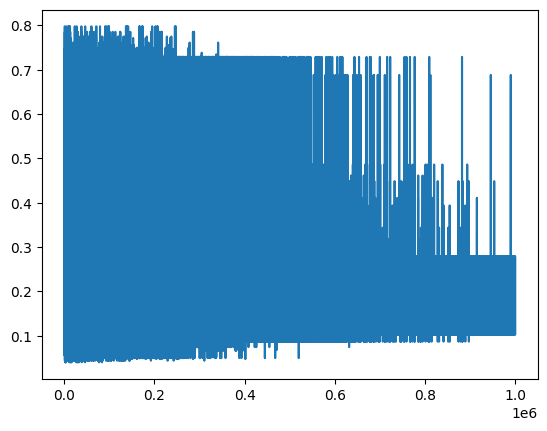

In [7]:
import matplotlib.pyplot as plt
plt.plot([reward[0] for reward in all_rewards])

In [10]:
game = interact.Interaction(beta=[10**(-3),10**(-5)])

In [11]:
cProfile.run('game(10**(6))', filename='profile_results.prof')

t: 0
average CPU 0.0009338855743408203
averages profits [0.18893341 0.32866262]
averages prices [1.73647943 1.50249749]
epsilon [1, 1]
t: 100000
average CPU 0.00011706808085651443
averages profits [0.28187645 0.29221661]
averages prices [1.72026286 1.70559073]
epsilon [3.7237979126550304e-44, 0.36788311998424805]
t: 200000
average CPU 0.00011171876122659791
averages profits [0.26416783 0.31418715]
averages prices [1.76267144 1.69030389]
epsilon [1.3852811154424512e-87, 0.1353366365962118]
t: 300000
average CPU 0.0001093167833425032
averages profits [0.25019035 0.33453021]
averages prices [1.7910234  1.67727138]
epsilon [5.153350997592663e-131, 0.04978756624103697]
t: 400000
average CPU 0.00010786562894508901
averages profits [0.24229459 0.34673823]
averages prices [1.80902745 1.67122512]
epsilon [1.9170857242147475e-174, 0.018315822046038845]
t: 500000
average CPU 0.0001069134428846926
averages profits [0.23727101 0.35618993]
averages prices [1.82381401 1.6691493 ]
epsilon [7.131704546

In [12]:
import pstats

# Load the profiling data from the saved file
profiler = pstats.Stats('profile_results.prof')  # Replace 'profile_results.prof' with your actual file path

# Sort the data by cumulative time spent in each function
profiler.strip_dirs()
profiler.sort_stats('cumulative')

# Print the profiling report (you can customize the number of lines shown)
profiler.print_stats(30)  # This will print the top 10 functions by cumulative time


Tue Oct 24 09:39:28 2023    profile_results.prof

         29048344 function calls (29047671 primitive calls) in 109.897 seconds

   Ordered by: cumulative time
   List reduced from 386 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  109.897  109.897 {built-in method builtins.exec}
        1    0.020    0.020  109.897  109.897 <string>:1(<module>)
        1    4.828    4.828  109.876  109.876 interactions.py:94(__call__)
  1000001   31.920    0.000  102.524    0.000 interactions.py:68(_single_game)
  2000002   10.218    0.000   28.495    0.000 qlearning2.py:115(updateQ)
  2000002    6.887    0.000   19.616    0.000 qlearning2.py:104(get_next_action)
  2000004    1.839    0.000   18.278    0.000 {method 'max' of 'numpy.ndarray' objects}
  2000004    1.159    0.000   16.439    0.000 _methods.py:39(_amax)
  2000407   15.288    0.000   15.288    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  2000002   1

In [20]:
game = interact.Interaction(beta=[10**(-3), 10**(-5)])
df = game(10**6)

t: 0
average CPU 0.0008842945098876953
averages profits [0.42308559 0.21866416]
averages prices [1.73647943 1.97046137]
epsilon [1, 1]
t: 100000
average CPU 0.00010626820630749991
averages profits [0.2564693  0.30554249]
averages prices [1.73879609 1.66311876]
epsilon [3.7237979126550304e-44, 0.36788311998424805]
t: 200000
average CPU 0.00011893522876440794
averages profits [0.24233276 0.33453234]
averages prices [1.79254973 1.66527597]
epsilon [1.3852811154424512e-87, 0.1353366365962118]
t: 300000
average CPU 0.00011976275339015675
averages profits [0.23324601 0.35466859]
averages prices [1.8302795  1.66988657]
epsilon [5.153350997592663e-131, 0.04978756624103697]
t: 400000
average CPU 0.00012110362234985374
averages profits [0.22748098 0.36685635]
averages prices [1.85220616 1.67210036]
epsilon [1.9170857242147475e-174, 0.018315822046038845]
t: 500000
average CPU 0.00011807874333470083
averages profits [0.22332863 0.37533745]
averages prices [1.86724778 1.67304122]
epsilon [7.1317045

In [14]:
df

,Iteration,Rewards,Prices,Epsilon
0,0,"[0.1306427005829202, 0.3239937485692055]","[1.6194884625723547, 1.970461374698752]","[1, 1]"
1,1000,"[0.26545967025743117, 0.26545967025743117]","[1.970461374698752, 1.7364794332811537]","[0.3682475046136629, 0.9900597342970082]"
2,2000,"[0.2500565214384913, 0.3358496627178654]","[1.8924673942262193, 1.658485452808621]","[0.13547068621005243, 0.9802084753424984]"
3,3000,"[0.23254260684730882, 0.2522244073701757]","[1.970461374698752, 1.541494482099822]","[0.0498368803380659, 0.9704552380523661]"
4,4000,"[0.15973704403838748, 0.4052636297998645]","[1.6194884625723547, 1.853470403989953]","[0.018333963688495727, 0.9607990470947544]"
...,...,...,...,...
997,997000,"[0.17764993956512787, 0.41151883566649017]","[1.9314643844624857, 1.6194884625723547]","[0.0, 4.678303129289746e-05]"
998,998000,"[0.17764993956512787, 0.41151883566649017]","[1.9314643844624857, 1.6194884625723547]","[0.0, 4.631753235381527e-05]"
999,999000,"[0.17764993956512787, 0.41151883566649017]","[1.9314643844624857, 1.6194884625723547]","[0.0, 4.585666520656653e-05]"
1000,1000000,"[0.17764993956512787, 0.41151883566649017]","[1.9314643844624857, 1.6194884625723547]","[0.0, 4.540038376405246e-05]"


t: 0
average CPU 0.004526853561401367
averages profits 0.32231101475629587
averages prices 1.6389869576904879
epsilon [1, 1]
t: 10000
average CPU 0.0024079084396362305
averages profits 0.24291599396298452
averages prices 1.6974824430448874
epsilon [0.9048464664553819, 0.9048464664553819]
t: 20000
average CPU 0.0017002423604329426
averages profits 0.3338455031058457
averages prices 1.6779839479267542
epsilon [0.8187389404264492, 0.8187389404264492]
t: 30000
average CPU 0.0013771653175354004
averages profits 0.282500336919126
averages prices 1.6974824430448874
epsilon [0.7408256289009657, 0.7408256289009657]
t: 40000
average CPU 0.001159524917602539
averages profits 0.2838572731303459
averages prices 1.7364794332811537
epsilon [0.6703267492696158, 0.6703267492696158]
t: 50000
average CPU 0.0010141531626383464
averages profits 0.28518877227357875
averages prices 1.8144734137536864
epsilon [0.6065367250495571, 0.6065367250495571]
t: 60000
average CPU 0.0009092944008963448
averages profits 

In [52]:
game2 = Interaction(alpha=[0.05, 0.2])
df2 = game2(10**(6))

t: 0
average CPU 0.0003459453582763672
averages profits 0.3131273132894379
averages prices 1.5024974918635556
epsilon [1, 1]
t: 100000
average CPU 0.00034999847412109375
averages profits 0.2805567072578414
averages prices 1.6779839479267542
epsilon [0.36788311998424805, 0.36788311998424805]
t: 200000
average CPU 0.0003276666005452474
averages profits 0.294584387615809
averages prices 1.658485452808621
epsilon [0.1353366365962118, 0.1353366365962118]
t: 300000
average CPU 0.00031620264053344727
averages profits 0.30820530415453423
averages prices 1.8144734137536864
epsilon [0.04978756624103697, 0.04978756624103697]
t: 400000
average CPU 0.00031037330627441405
averages profits 0.28446709468631864
averages prices 1.7169809381630206
epsilon [0.018315822046038845, 0.018315822046038845]
t: 500000
average CPU 0.0003204743067423503
averages profits 0.28472879277612634
averages prices 1.6389869576904879
epsilon [0.006738014378892354, 0.006738014378892354]
t: 600000
average CPU 0.000315087182181

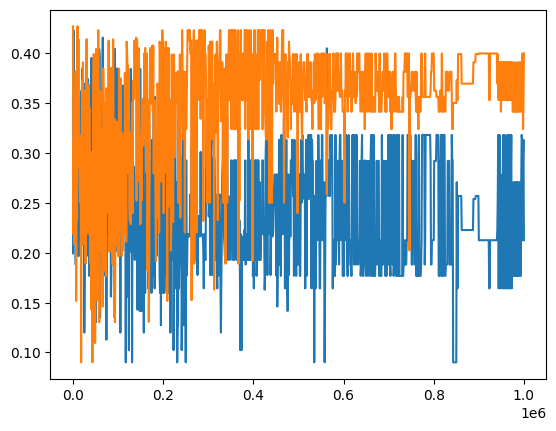

In [54]:
import matplotlib.pyplot as plt
plt.plot(df2['Iteration'], [reward[0] for reward in df2['Rewards']])
plt.plot(df2['Iteration'], [reward[1] for reward in df2['Rewards']])